In [4]:
%%capture
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from scipy import integrate
from scipy import interpolate
import math

from scipy import signal
import pandas as pd
import tensorflow as tf
import os
from sklearn.preprocessing import MinMaxScaler
from IPython.display import display, HTML
%run KalmanFilter.ipynb

In [5]:
# from tf.keras.models import Sequential  # This does not work!
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Input, Dense, GRU, Embedding
from tensorflow.python.keras.optimizers import RMSprop
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from tensorflow.python.keras import backend as K 
from IPython.display import clear_output
from tensorflow.python.keras.initializers import RandomUniform

## Load DataStream and Ground Truth
As no reliable ground truth currently, using Kalman Filter results. Note: Ground truth must currently have the same timesteps as the input.

https://github.com/Hvass-Labs/TensorFlow-Tutorials/blob/master/23_Time-Series-Prediction.ipynb

Parsed File
Freq. of Acceleration 1583.554443181799
Freq. of Lin. Acceleration 669.8833983859098
Freq. of Gyroscope 1585.3892195648934
Loaded Ground Truth
Interpolated Samples
Rotated Acceleration
Integrated Acceleration


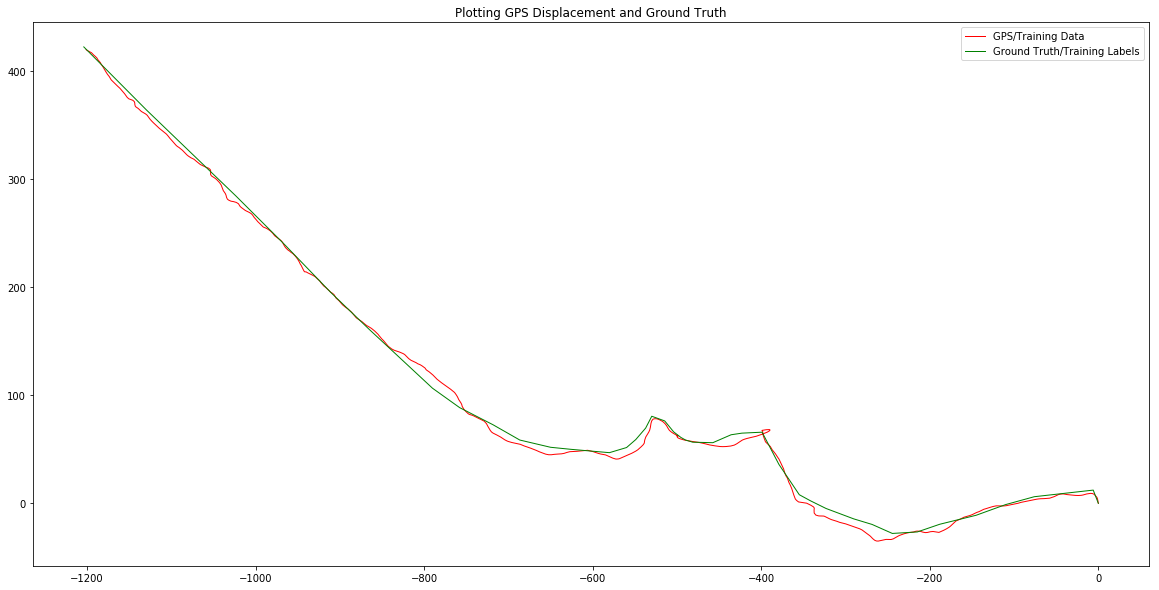

In [6]:
# %load_ext line_profiler
# %lprun -T lprof0 -f Data_Stream.__init__ Data_Stream('uni.csv')
# %cat lprof0

data = Data_Stream('data5.csv')


compute_kalman(data)
plt.figure(figsize=(20, 10))
ax=plt.subplot(111)
plt.plot(data.gps[:, 1], data.gps[:, 2], 'r-', lw=1, label='GPS/Training Data ') ##
# plt.plot(data.kal_dis[:, 1], data.kal_dis[:, 2], 'g-', lw=1, label='Kalman or Training Labels') ##Training Labels
plt.plot(data.ground_truth.dis[:, 1], data.ground_truth.dis[:, 2], 'g-', lw=1, 
         label='Ground Truth/Training Labels') ##Training Labels
plt.title("Plotting GPS Displacement and Ground Truth") 
ax.legend()

### Get input data and correct labels in the right form

Parameter for choosing whether how much of data stream is training/test data

In [7]:
def create_input_and_output(data, ground_truth, just_acc=False):
    ## Needed Data
    gps = data.gps[:, 1:3]
    acc = data.acc_ERC[:, 1:3]
    vel = data.vel_ERC[:, 1:3]
    mag = data.mag[:, 1:3]
    gyro = data.gyro[:, 1:4]

    time_series = data.acc_ERC[:, 0]
#     ground_truth = data.kal_dis[:, 1:3]
    ground_truth = data.ground_truth.dis[:, 1:3]
    delta_time = np.diff(time_series, axis=0)
    delta_time = np.concatenate(([[0]], delta_time))

    # Choose which data to include in input
    if (just_acc):
        input_data = np.concatenate((gps, acc, delta_time), axis=1)
    else:
        input_data = np.concatenate((gps, acc, delta_time), axis=1)
    return input_data, ground_truth

## Split data for training and testing
input_data, ground_truth = create_input_and_output(data)
x_dim = input_data.shape[1]
y_dim = ground_truth.shape[1]
print("X Dim: ", x_dim)

num_train = int(0.70*input_data.shape[0])
num_test = input_data.shape[0] - num_train

training_data   = input_data[:num_train, :]
training_labels = ground_truth[:num_train, :]

test_data     = input_data[num_train:, :]
test_labels   = ground_truth[num_train:, :]

X Dim:  5


### Print Data with Pandas

Training Data


,GPS X,GPS Y,Acc X,Acc Y,Delta Time,Ground Truth X,Ground_Truth Y
0,0.0,0.0,-0.231399,0.051390,0.00000,0.000000,0.000000
1,0.0,0.0,0.282160,0.172447,0.03281,-0.013851,0.028485
2,0.0,0.0,0.268599,0.162328,0.00250,-0.014907,0.030655
3,0.0,0.0,0.294182,0.059796,0.00507,-0.017047,0.035057
4,0.0,0.0,-0.018827,0.021122,0.03784,-0.033022,0.067909


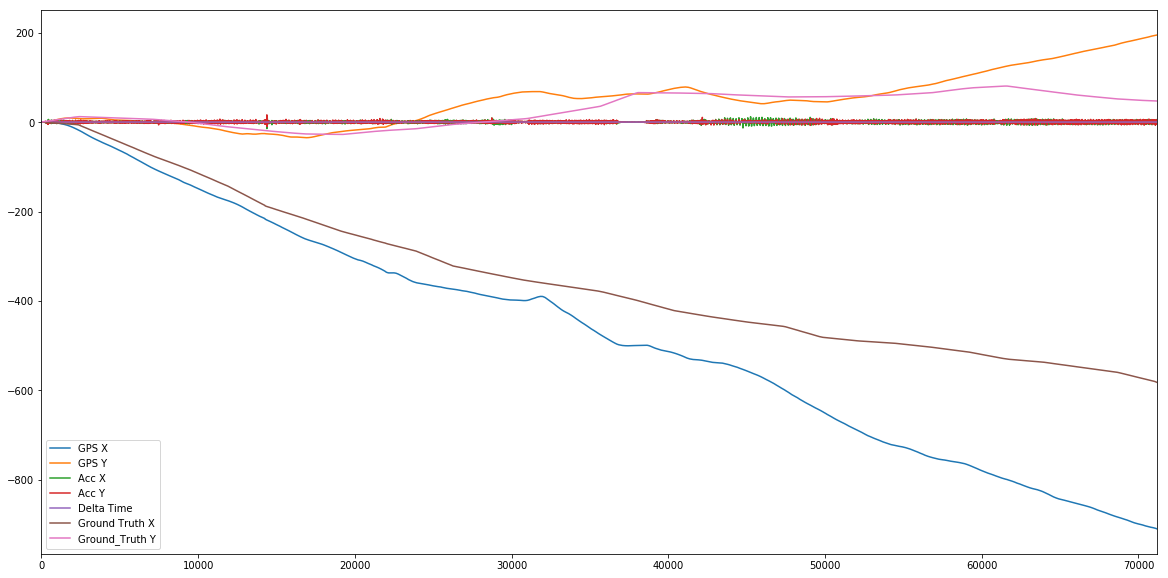

In [8]:
if(False):
    training_frame = pd.DataFrame(np.concatenate((training_data, training_labels), axis=1), 
                                                 columns=['GPS X', 'GPS Y', 'Acc X', 'Acc Y', 
                                                          'Delta Time', 'Ground Truth X', 'Ground_Truth Y'])
else:
    training_frame = pd.DataFrame(np.concatenate((training_data, training_labels), axis=1), 
                                                 columns=['GPS X', 'GPS Y', 'Acc X', 'Acc Y',
#                                                           'Vel X', 'Vel Y',
#                                                           'Mag X', 'Mag Y',
#                                                           'Gyro X', 'Gyro Y', 'Gyro Z',
                                                          'Delta Time', 'Ground Truth X', 'Ground_Truth Y'])
print("Training Data")
display(training_frame.head(5))
training_frame.plot(figsize=(20,10))

In [9]:
if(False):
    test_frame = pd.DataFrame(np.concatenate((test_data, test_labels), axis=1), 
                                                 columns=['GPS X', 'GPS Y', 'Acc X', 'Acc Y', 
                                                          'Delta Time', 'Ground Truth X', 'Ground_Truth Y'])
else:
    test_frame = pd.DataFrame(np.concatenate((test_data, test_labels), axis=1), 
                                                 columns=['GPS X', 'GPS Y', 'Acc X', 'Acc Y',
#                                                           'Vel X', 'Vel Y',
#                                                           'Mag X', 'Mag Y',
#                                                           'Gyro X', 'Gyro Y', 'Gyro Z',
                                                          'Delta Time', 'Ground Truth X', 'Ground_Truth Y'])
print("Testing Data")
display(test_frame.head(5))
# test_frame.plot(figsize=(20,10))


Testing Data


,GPS X,GPS Y,Acc X,Acc Y,Delta Time,Ground Truth X,Ground_Truth Y
0,-909.920231,194.807975,-4.323784,4.593242,0.00503,-582.432979,47.011870
1,-909.932305,194.813150,-4.181739,4.310117,0.00504,-582.445107,47.012666
2,-909.944426,194.818345,-3.908450,3.990322,0.00506,-582.457283,47.013464
3,-909.956499,194.823519,-3.533563,3.759087,0.00504,-582.469411,47.014260
4,-909.962560,194.826116,-3.153301,3.613711,0.00253,-582.475500,47.014659


### Create Scaling Object to Scale down data to between 0 and 1

In [10]:
x_scaler = MinMaxScaler()
custom_scale_matrix = np.zeros((2, x_dim))
custom_scale_matrix.fill(5000)
custom_scale_matrix[1, :] = -custom_scale_matrix[1 , :]
print(custom_scale_matrix)

x_scaler = x_scaler.fit(custom_scale_matrix)

scaled_training_data = x_scaler.transform(training_data)
scaled_test_data = x_scaler.transform(test_data)

print("Min: ", np.min(training_data[:, 0]), " Max: ", np.max(training_data[:, 0]))
print("Min: ", np.min(scaled_training_data[:, 0]), " Max: ", np.max(scaled_training_data[:, 0]))



[[ 5000.  5000.  5000.  5000.  5000.]
 [-5000. -5000. -5000. -5000. -5000.]]
Min:  -909.9081817366505  Max:  0.0
Min:  0.40900918182633494  Max:  0.5


In [11]:
y_scaler = MinMaxScaler()

y_scaler = y_scaler.fit(custom_scale_matrix[:, 0:2])

scaled_training_labels = y_scaler.transform(training_labels)
scaled_test_labels = y_scaler.transform(test_labels)

print("Min: ", np.min(training_labels), " Max: ", np.max(training_labels))
print("Min: ", np.min(scaled_training_labels), " Max: ", np.max(scaled_training_labels))

scaled_training_frame = pd.DataFrame(np.concatenate((scaled_training_data, scaled_training_labels), axis=1), 
                                                 columns=['GPS X', 'GPS Y', 'Acc X', 'Acc Y',
#                                                           'Vel X', 'Vel Y',
#                                                           'Mag X', 'Mag Y',
#                                                           'Gyro X', 'Gyro Y', 'Gyro Z',
                                                          'Delta Time', 'Ground Truth X', 'Ground_Truth Y'])

# training_frame.plot(figsize=(20,10))
# scaled_training_frame.plot(figsize=(20,10))

Min:  -582.4208747467412  Max:  80.64052328931963
Min:  0.44175791252532587  Max:  0.5080640523289319


### Define Batch Generator
Data is currently in a form of N observations, with 5/14 input signals and 2 ouput signals. To be processes by tensorflow 
layers, this is converted to batches of sequences of observations

In [12]:
print(scaled_training_data.shape)
print(scaled_training_labels.shape)

(71218, 5)
(71218, 2)


In [31]:
def batch_generator(batch_size, sequence_length):
    
#     # Infinite loop.
#     while True:
#         # Allocate a new array for the batch of input-signals.
#         x_shape = (batch_size, sequence_length, x_dim)
#         x_batch = np.zeros(shape=x_shape, dtype=np.float16)

#         # Allocate a new array for the batch of output-signals.
#         y_shape = (batch_size, sequence_length, y_dim)
#         y_batch = np.zeros(shape=y_shape, dtype=np.float16)

#         # Fill the batch with random sequences of data.
#         for i in range(batch_size):
#             # Get a random start-index.
#             # This points somewhere into the training-data.
# #             rand_start = np.random.randint(num_train - sequence_length)
            
#             # Copy the sequences of data starting at this index.
# #             x_batch[i] = scaled_training_data[rand_start : rand_start + sequence_length]
# #             y_batch[i] = scaled_training_labels[rand_start : rand_start + sequence_length]
            
#             x_batch[i] = scaled_training_data[i*sequence_length: i*sequence_length + sequence_length]
#             y_batch[i] = scaled_training_labels[i*sequence_length: i*sequence_length + sequence_length]
        
#         yield (x_batch, y_batch)
        
        
    # Infinite loop.
    while True:
        # Allocate a new array for the batch of input-signals.
        x_shape = (batch_size, sequence_length, x_dim)
        x_batch = np.zeros(shape=x_shape, dtype=np.float16)

        # Allocate a new array for the batch of output-signals.
        y_shape = (batch_size, sequence_length, y_dim)
        y_batch = np.zeros(shape=y_shape, dtype=np.float16)

        # Fill the batch with random sequences of data.
        for i in range(batch_size):
            # Get a random start-index.
            # This points somewhere into the training-data.
            rand_start = np.random.randint(num_train - sequence_length)
            
            # Copy the sequences of data starting at this index.
            x_batch[i] = scaled_training_data[rand_start : rand_start + sequence_length]
            y_batch[i] = scaled_training_labels[rand_start : rand_start + sequence_length]
        
        yield (x_batch, y_batch)

In [32]:
sess = tf.InteractiveSession()

generator = batch_generator(batch_size=256, sequence_length=100)
x_batch, y_batch = next(generator)
print(x_batch.shape)

(256, 100, 5)


(256, 100, 5)
(256, 100, 2)


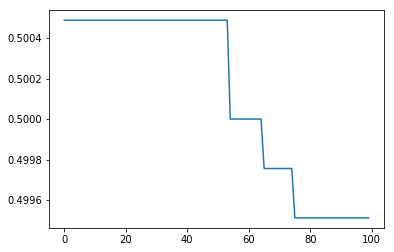

In [33]:
print(x_batch.shape)
print(y_batch.shape) 
batch = 0   # First sequence in the batch.
signal = 2  # Signal, GPS looks like steps as is interpolated at low frequency
seq = x_batch[batch, :, signal]
plt.plot(seq)

In [34]:
validation_data = (np.expand_dims(scaled_test_data, axis=0), np.expand_dims(scaled_test_labels, axis=0))

In [35]:

model = Sequential()
model.add(GRU(units=512, return_sequences=True, input_shape=(None, x_dim,)))#
model.add(Dense(y_dim, activation='linear'))


In [36]:
warmup_steps = 3


In [47]:
def loss_mse_warmup(y_true, y_pred):
    
    y_true_slice = y_true[:, warmup_steps:, :]
    y_pred_slice = y_pred[:, warmup_steps:, :]
    
    
#     ts = tf.reshape(y_true_slice, (-1, 2))
    
#     ps = y_pred_slice
    
#     def get_min_dist(pi):
#         print(pi.get_shape(), ts.get_shape())
#         eu_dists = tf.norm(ts-pi, ord='euclidean', axis=1)
#         min_dist = tf.reduce_min(eu_dists)
#         return min_dist


#     min_dists = tf.map_fn(get_min_dist, tf.reshape(ps, (-1, 2)), dtype=tf.float32)
#     print("Minimum distances to Ground Truth Points Shape", min_dists.get_shape())
#     mean_dist = tf.reduce_mean(min_dists)
#     print("Mean Mimimum Distance Shape", mean_dist.get_shape()

    eu_dists = tf.norm(y_true_slice-y_pred_slice, ord='euclidean')
    loss_mean = tf.reduce_mean(eu_dists)
    
    return loss_mean

In [48]:
optimizer = RMSprop(lr=1e-3)
model.compile(loss=loss_mse_warmup, optimizer=optimizer)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, None, 512)         795648    
_________________________________________________________________
dense (Dense)                (None, None, 2)           1026      
Total params: 796,674
Trainable params: 796,674
Non-trainable params: 0
_________________________________________________________________


In [49]:
# path_checkpoint = '23_checkpoint.keras'
# callback_checkpoint = ModelCheckpoint(filepath=path_checkpoint,
#                                       monitor='val_loss',
#                                       verbose=1,
#                                       save_weights_only=True,
#                                       save_best_only=True)
callback_early_stopping = EarlyStopping(monitor='val_loss',
                                        patience=3, verbose=1)
# callback_tensorboard = TensorBoard(log_dir='./23_logs/',
#                                    histogram_freq=0,
#                                    write_graph=False)
callback_reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                                       factor=0.1,
                                       min_lr=1e-6,
                                       patience=0,
                                       verbose=1)

class PlotLosses(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        
        self.fig = plt.figure(figsize=(20, 10))
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.i += 1
        
        clear_output(wait=True)
        plt.figure(figsize=(20, 10))
        plt.plot(self.x, self.losses, label="loss")
        plt.plot(self.x, self.val_losses, label="val_loss")
        plt.legend()
        plt.show();
        
plot_losses = PlotLosses()

callbacks = [callback_early_stopping,
#              callback_checkpoint,
#              callback_tensorboard,
             plot_losses,
             callback_reduce_lr]


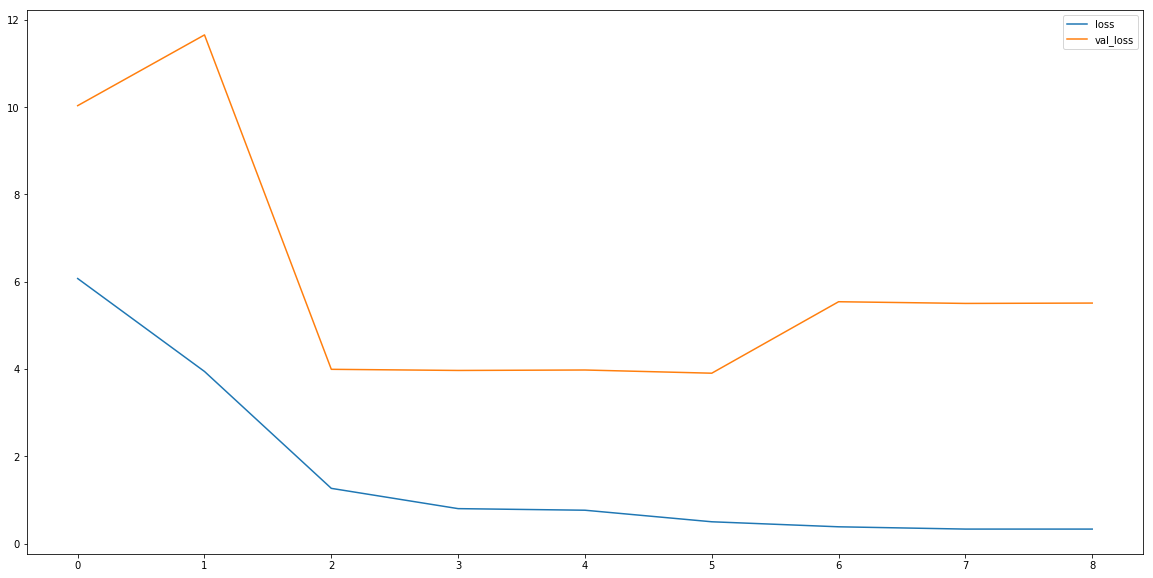

100/100 [==============================] - 18s 180ms/step - loss: 0.3317 - val_loss: 5.5092
Epoch 00009: early stopping
CPU times: user 3min 24s, sys: 11.6 s, total: 3min 36s
Wall time: 2min 47s


In [50]:
%%time
# model.fit(np.expand_dims(scaled_training_data, axis=0), np.expand_dims(scaled_training_labels, axis=0), epochs=10, 
#           batch_size=32, validation_data=validation_data, callbacks=callbacks)
model.fit_generator(generator=generator,
                    epochs=30,
                    steps_per_epoch=100, #Number of batches per epoch
                    validation_data=validation_data,
                    callbacks=callbacks)

In [51]:
result = model.evaluate(x=np.expand_dims(scaled_test_data, axis=0),
                        y=np.expand_dims(scaled_test_labels, axis=0))
print("loss (test-set):", result)

1/1 [==============================] - 8s 8s/step
loss (test-set): 5.50924825668335


In [52]:
def plot_comparison(trial_input, ground_truth_output, orig_gps, start_index, length=100, train=True):
    """
    Plot the predicted and true output-signals.
    
    :param start_index: Start-index for the time-series.
    :param length: Sequence-length to process and plot.
    :param train: Boolean whether to use training- or test-set.
    """
    trial_input = x_scaler.transform(trial_input)
#     if train:
#         trial_input = scaled_training_data
#         ground_truth_output = training_labels
#     else:
#         trial_input = scaled_test_data
#         ground_truth_output = test_labels
    
    # End-index for the sequences.
    end_index = start_index + length
    
    trial_input = trial_input[start_index : end_index]
    ground_truth_output = ground_truth_output[start_index : end_index]
    
    # Make 3D
    trial_input = np.expand_dims(trial_input, axis=0)
    
    # Predict output
    predicted_output = model.predict(trial_input)
    
    # The output of the model is between 0 and 1. Inverse rescale to get input
    predicted_output = y_scaler.inverse_transform(predicted_output[0])
    
    for signal in range(ground_truth_output.shape[1]):
        
        # Make the plotting-canvas bigger.
        plt.figure(figsize=(15,5))
        
        # Plot and compare the ground truth and Model predicted versions
        plt.plot(ground_truth_output[:, signal], label='true')
        plt.plot(predicted_output[:, signal], label='pred')
        
        # Plot grey box for warmup-period.
        p = plt.axvspan(0, warmup_steps, facecolor='red', alpha=0.15)
        
        # Plot labels etc.
        plt.ylabel("X Displacement" if signal == 0 else "Y Displacement")
        plt.xlabel("Timestep")
        plt.legend()
        plt.show()
        
#     # Make the plotting-canvas bigger.
    plt.figure(figsize=(15,5))

    # Plot and compare the two signals.
    plt.plot(ground_truth_output[:, 0], ground_truth_output[:, 1], label='true', color = 'g')
    plt.plot(predicted_output[:, 0], predicted_output[:, 1], label='predicted', color = 'b')
    plt.plot(orig_gps[start_index:, 1], orig_gps[start_index:, 2], label='original gps', color = 'r')
    plt.legend()
    plt.show()
        

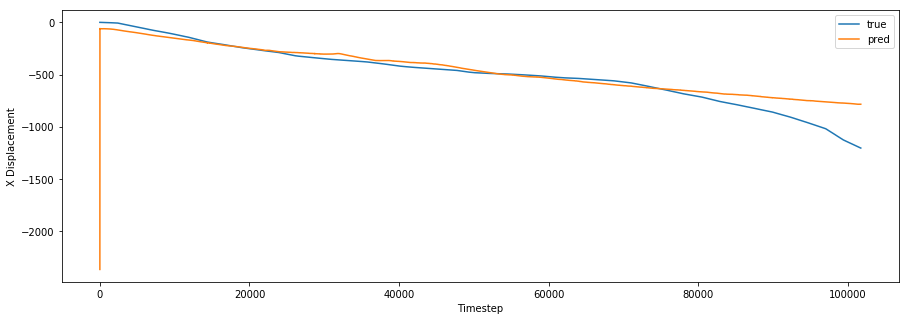

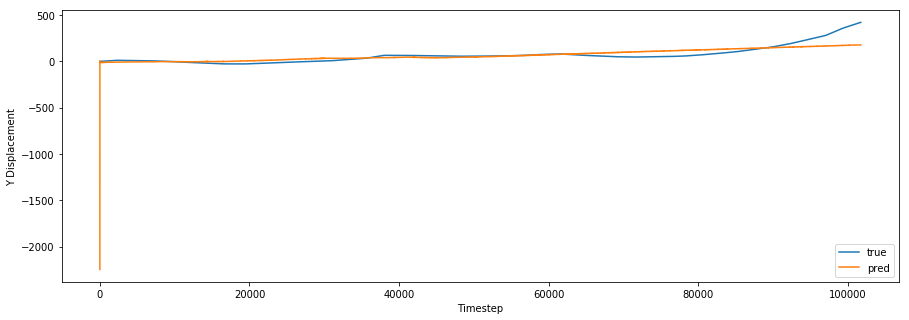

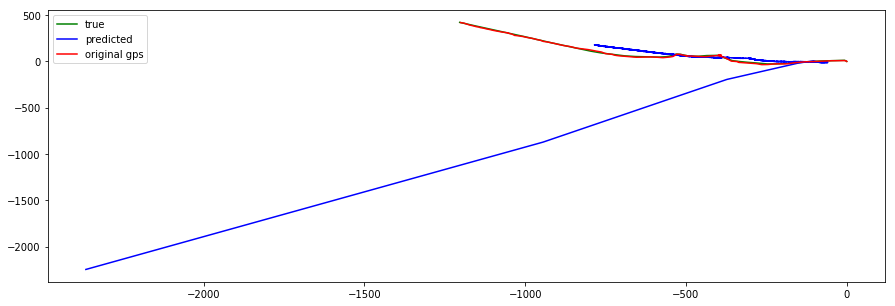

In [43]:
warmup_steps=20
plot_comparison(input_data, ground_truth, data.gps, start_index=warmup_steps, length=num_train+num_test, train=True)

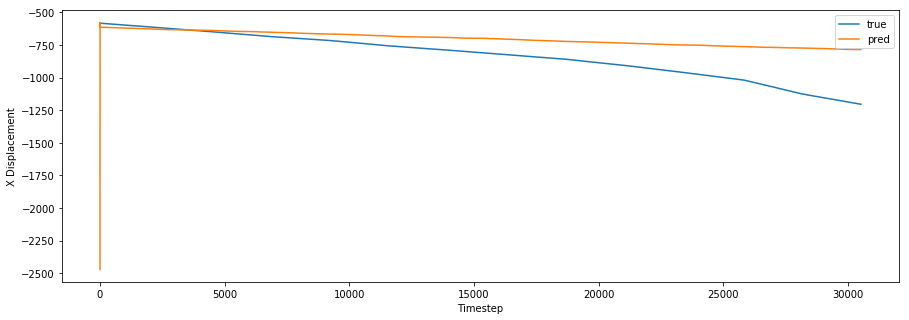

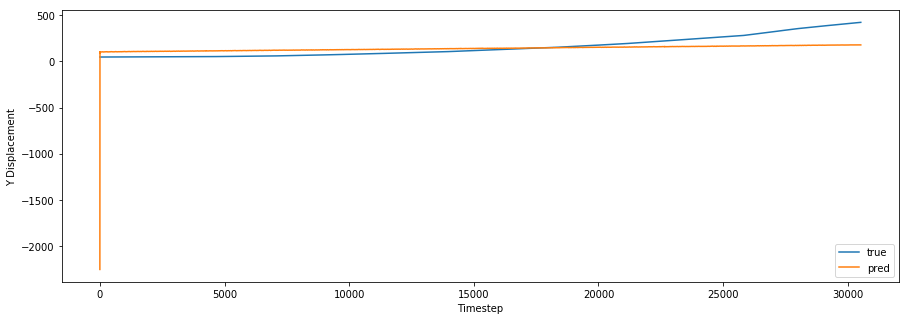

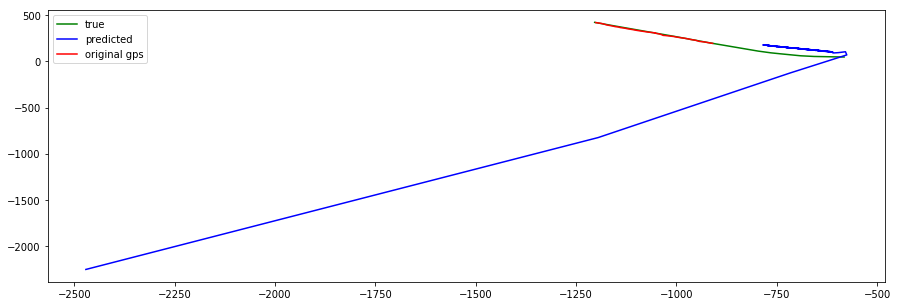

In [44]:
plot_comparison(input_data, ground_truth, data.gps, start_index=num_train, length=num_test, train=True)

In [46]:
data2 = Data_Stream('data5.csv')
compute_kalman(data2)

input_data2, ground_truth2 = create_input_and_output(data2)
plot_comparison(input_data2, ground_truth2, data2.gps, start_index=warmup_steps, length=len(input_data2), train=True)

Parsed File
Freq. of Acceleration 190.0300697928473
Freq. of Lin. Acceleration 49.00211454776328
Freq. of Gyroscope 52.67300802601869


ValueError: could not convert string to float: '\ufeffType'

In [30]:
tf.reset_default_graph()
sess.close()